# ISLR- Python Ch 8 Applied 9

- [Import OJ Dataset](#Import-OJ-Dataset)
- [Split Data](#Split-Data)
- [Fit a Classification Tree](#Fit-a-Classification-Tree)
- [Predict Response on Test Data](#Predict-Response-on-Test-Data)
- [Validation for Optimal Tree Size](#Validation-for-Optimal-Tree-Size)
- [Compare Train/Test Error Rates](#Compare-Train/Test-Error-Rates)

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

from sklearn.cross_validation import train_test_split
from sklearn.tree import tree, export_graphviz
from sklearn.metrics import confusion_matrix
from IPython.display import Image, display

%matplotlib inline
plt.style.use('ggplot')

## Load OJ Dataset

In [5]:
df = pd.read_csv('../../../data/OJ.csv', index_col=0)
# create dummy variables for the categoricals
df = pd.get_dummies(df, columns=['Store7'])
df.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE,Store7_No,Store7_Yes
1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0.000000,0.000000,0.24,1,1.0,0.0
2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0.150754,0.000000,0.24,1,1.0,0.0
3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0.000000,0.091398,0.23,1,1.0,0.0
4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0.000000,0.000000,0.00,1,1.0,0.0
5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,0.000000,0.000000,0.00,0,0.0,1.0


## Split Data

In [12]:
# get the predictors
predictors = df.columns.tolist()
predictors.remove('Purchase')
X = df[predictors].values

# get the response i.e. Purchase
y = df.Purchase.values.reshape(-1,1)

# make a split using 800 samples for training and the remainder for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=800, random_state=0)

## Fit a Classification Tree

In [91]:
# fit a deep tree stopping when only 5 instances in each leaf.  See sklearn doc for defaults
unpruned_tree = tree.DecisionTreeClassifier(min_samples_leaf=5).fit(X_train,y_train)

# compute the training error rate
train_error = 1-np.mean(unpruned_tree.predict(X_train).reshape(-1,1)==y_train)
print('Training Error Rate = ', train_error)

# how many terminal nodes
print("Number of Leaves = ", unpruned_tree.tree_.node_count)

Training Error Rate =  0.11375
Number of Leaves =  141


## Plot the Tree

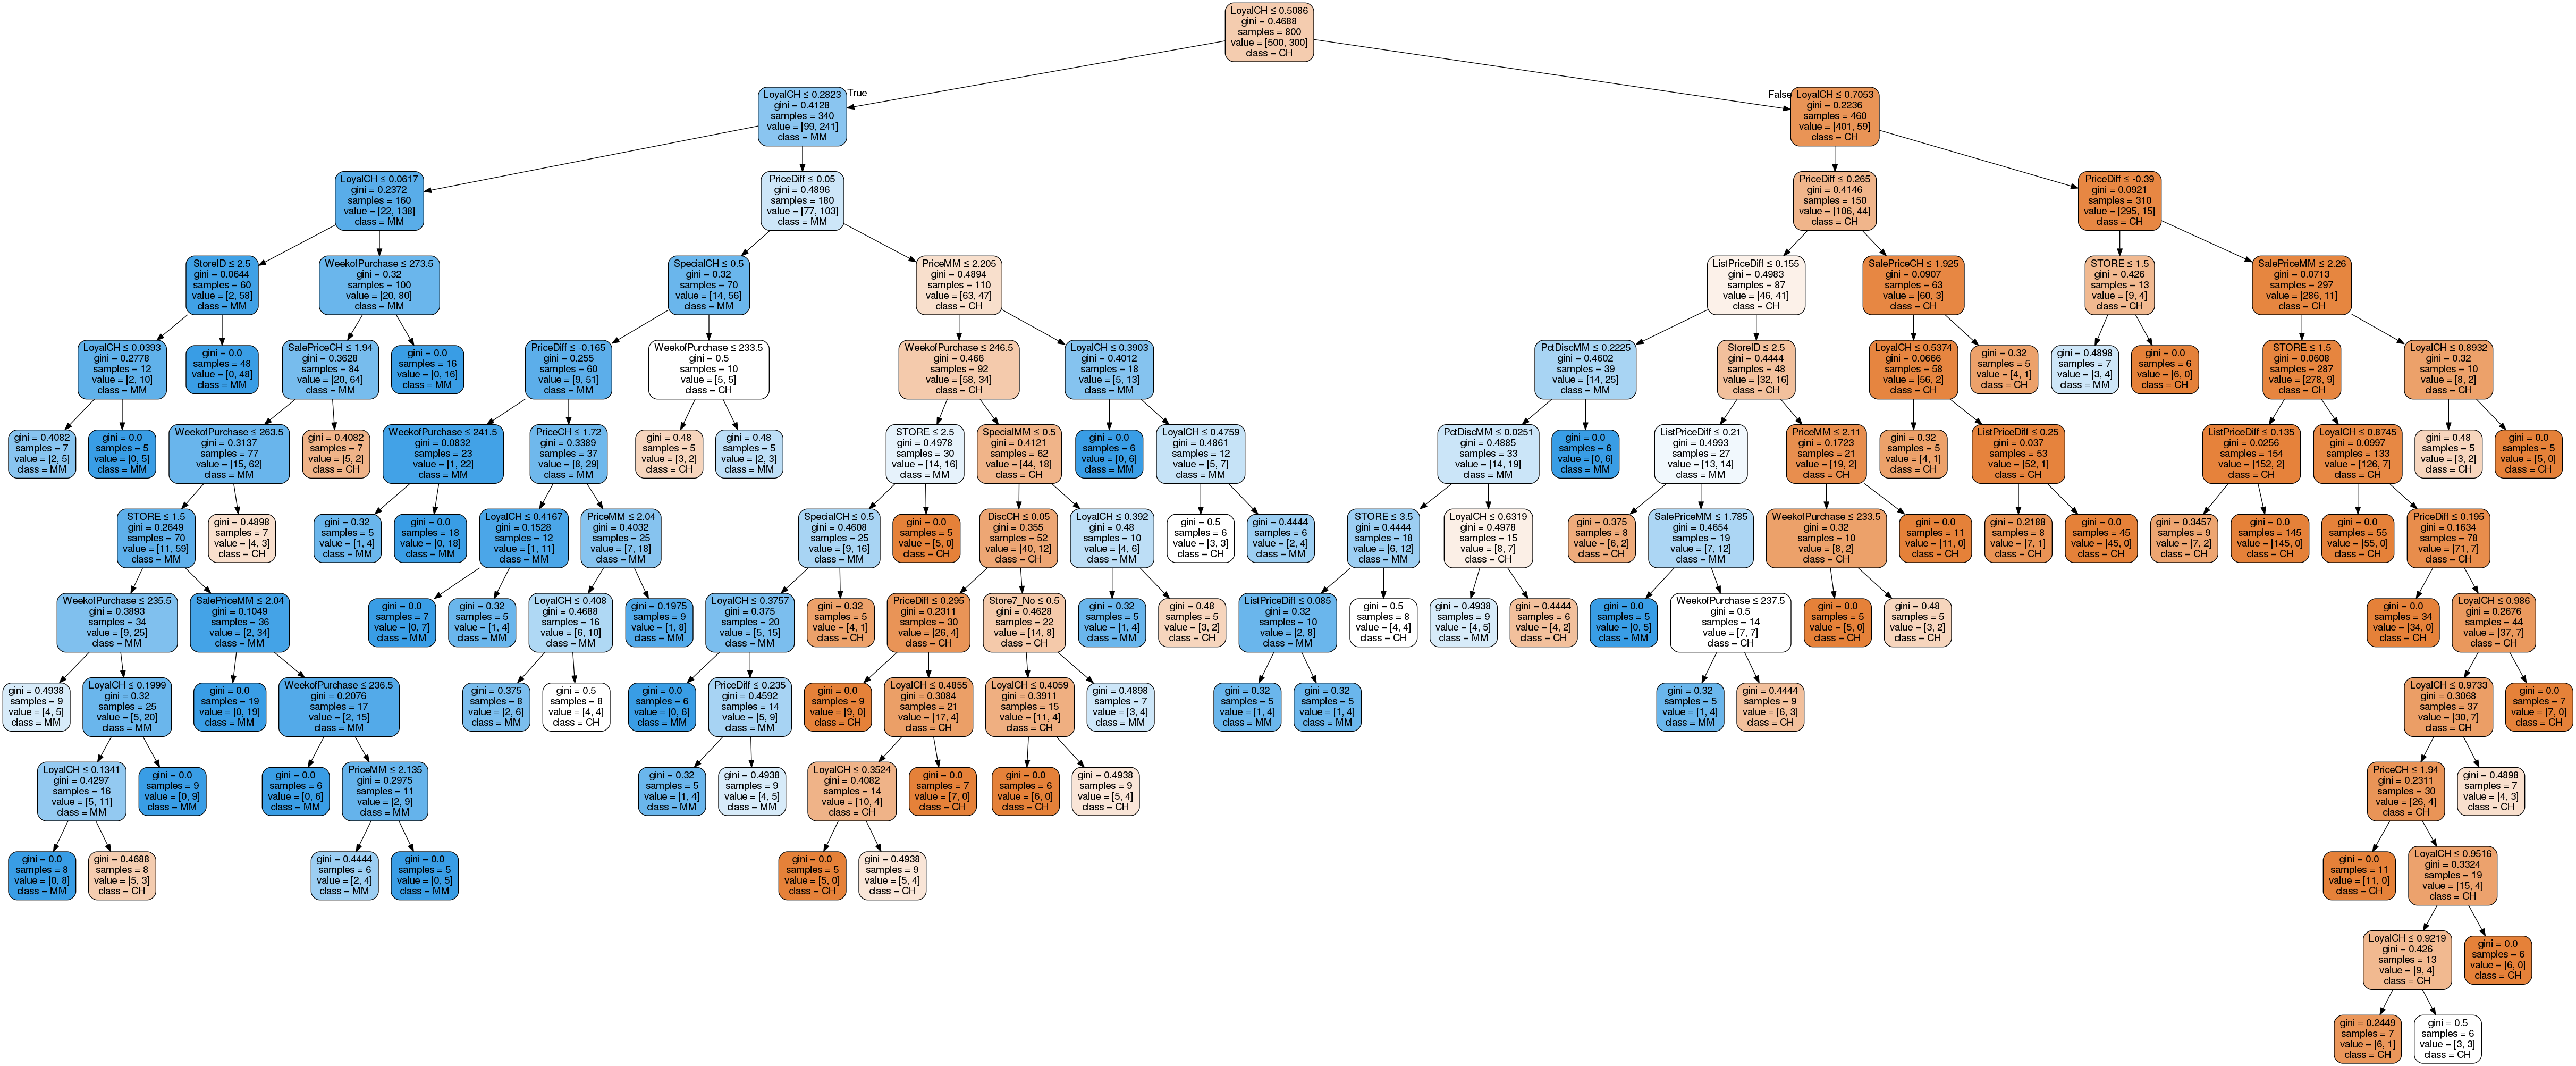

In [92]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(unpruned_tree, out_file='oj_tree.dot',feature_names=predictors, 
                class_names=['CH', 'MM'],filled=True, rounded=True,  
                        special_characters=True)

with open('oj_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

In [60]:
# also show the view of the source object in browser so we can zoom in on nodes and see what we've got
I.view()

'Source.gv.png'

The feature LoyalCH is the first split in the tree and is then followed by LoyalCH and PriceDiff splits. These splits very quickly segregate the CH and MM classes. In fact on the right hand split if LoyalCH < .7 the CH,MM values are 401,59 by the second split indicating that LoyalCH is an important splitting feature in reducing the GINI Index.

## Predict Response on Test Data

In [93]:
# predictions
y_pred = unpruned_tree.predict(X_test).reshape(-1,1)

# get the test error
test_error = 1-np.mean(y_pred==y_test)
print('Test Error Rate = ', test_error)

# Lets also get the confusion matrix of the tree estimate
cmatrix = confusion_matrix(y_true = y_test, y_pred=unpruned_tree.predict(X_test), labels=['CH', 'MM'])
print(cmatrix)

Test Error Rate =  0.218518518519
[[123  30]
 [ 29  88]]


## Validation for Optimal Tree Size

Sklearn does not provide a method for pruning a tree but we can still make trees of various sizes and use validation to determine which tree size performs best on a test data set. 

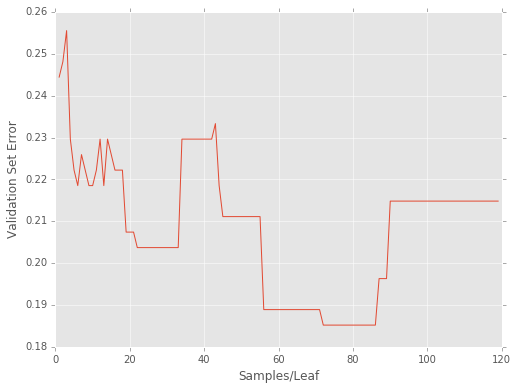

In [94]:
errors=[]
for sample in range(1,120):
        # make a tree
        tree_est = tree.DecisionTreeClassifier(min_samples_leaf=sample).fit(X_train,y_train)
        # compute the trees test error rate on the validation set (note the question is asked in a way that
        # indicates we should use a validation approach but cross validation could be used here too.)
        errors.append(1-np.mean(tree_est.predict(X_test).reshape(-1,1)==y_test))
        
# plt the errors as a function of the number of samples/leaf 
fig, ax =plt.subplots(1,1,figsize=(8,6))
ax.plot(range(1,120), errors);
ax.set_xlabel('Samples/Leaf');
ax.set_ylabel('Validation Set Error');

In [95]:
# Get the size of the best tree ~ 80 samples/leaf
pruned_tree = tree.DecisionTreeClassifier(min_samples_leaf=80).fit(X_train,y_train)
pruned_tree.tree_.max_depth

4

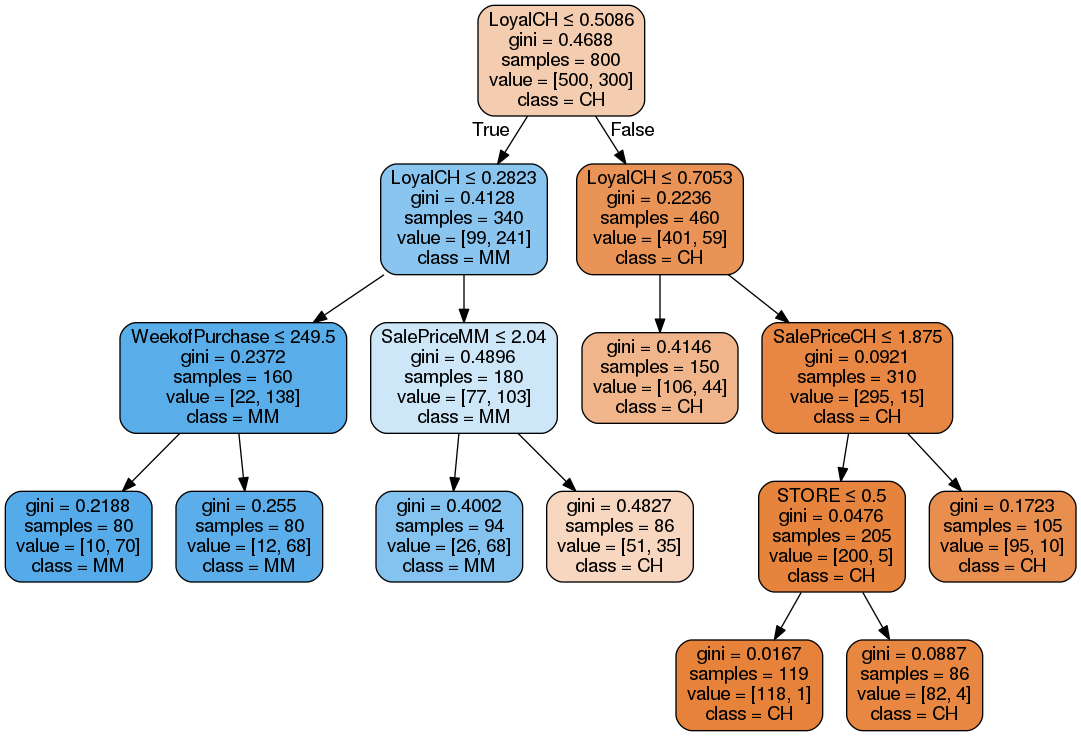

In [96]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(pruned_tree, out_file='oj_pruned_tree.dot',feature_names=predictors, 
                class_names=['CH', 'MM'],filled=True, rounded=True,  
                        special_characters=True)

with open('oj_pruned_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

So the best performing tree on the test dataset is a depth 4 tree corresponding to 80 samples per leaf. Now lets compare the training and test error rates using this tree.

## Compare Train/Test Error Rates

In [98]:
unpruned_training_err = 1-np.mean(unpruned_tree.predict(X_train).reshape(-1,1)==y_train)
pruned_training_err = 1-np.mean(pruned_tree.predict(X_train).reshape(-1,1)==y_train)
print('Unpruned Training Error = ', unpruned_training_err)
print('Pruned Training Error = ', pruned_training_err)

unpruned_test_err = 1-np.mean(unpruned_tree.predict(X_test).reshape(-1,1)==y_test)
pruned_test_err = 1-np.mean(pruned_tree.predict(X_test).reshape(-1,1)==y_test)
print('Unpruned Test Error = ', unpruned_test_err)
print('Pruned Test Error = ', pruned_test_err)

Unpruned Training Error =  0.11375
Pruned Training Error =  0.1775
Unpruned Test Error =  0.218518518519
Pruned Test Error =  0.185185185185


As expected, the training error is higher for the pruned tree but the test error drops. This makes perfect sense because we are sacrificing an increase in the trees bias for a larger decrease in the tree's variablility.